In [246]:
# Load some modules
import numpy as np
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import ascii
from mpl_toolkits.basemap import Basemap

In [247]:
# Read in the data and see what it looks like.
# I downloaded the APERTIF Observation Record spreadsheet as a csv file and kept 
# the RFI scans in a file:
rfi_scans = ascii.read('APERTIFObservationRecord-happili.RFI.18mar29.csv')
print rfi_scans[0:3]

col1       col2          col3           col4        ... col16 col17 col18
---- ---------------- --------- ------------------- ... ----- ----- -----
   ? 180323023_RFI109 180323023 2018-03-26 00:00:00 ...   VAM    BH    --
   ? 180323020_RFI130 180323020 2018-03-25 15:05:00 ...   VAM    BH    --
   ? 180323018_RFI114 180323018 2018-03-25 09:00:00 ...   VAM    BH    --


In [248]:
# Set position of Westerbork (source: http://www.sonel.org/spip.php?page=gps&idStation=884)
westerbork = EarthLocation(lat= 52.91460037*u.deg, lon=6.60449982*u.deg, height=82.2786*u.m)
utcoffset = +1*u.hour  # Central European Time
utcsummer = +2*u.hour  # Central European Summer Time (not used below)

# How often do you want to plot the Alt-Az positions:
per_hour = 10*u.minute
n_segments = int(60*3/per_hour.value)+1

starttimeUTC = np.zeros(len(rfi_scans), dtype=object)
endtimeUTC = np.zeros(len(rfi_scans), dtype=object)
obj_altazs = np.zeros([len(rfi_scans),n_segments], dtype=object)

# Make an 2-D array of the changing Alt-Az positions for each RFI scan:
for i in range(len(rfi_scans)):
    starttimeUTC[i] = Time(rfi_scans['col4'][i]) - utcoffset
    endtimeUTC[i] = Time(rfi_scans['col5'][i]) - utcoffset
    time_iter=starttimeUTC[i]
    j=0
    while time_iter < endtimeUTC[i]:
        #print time_iter
        obj_altazs[i,j]=obj.transform_to(AltAz(obstime=time_iter,location=westerbork))
        time_iter=time_iter+per_hour
        j+=1

In [249]:
# Choose a color map to plot the points so scans have the same color.
# I chose prism because there are lots of colors and it wraps.
cmap=plt.cm.prism
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(rfi_scans))

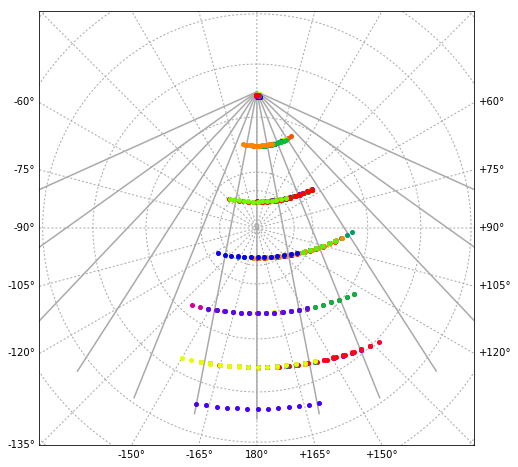

In [250]:
# Set up the map projection
plt.figure(figsize=[8,8])
m = Basemap(projection='nplaea',boundinglat=29,lon_0=180,resolution='l0',celestial=True)
m.drawparallels(np.arange(0,100,15),labels=[False,False,False,False],color='darkgray')
m.drawmeridians(np.arange(0,360,15),labels=[True,True,False,True],color='darkgray',latmax=90)

# Plot lines of constant +/-6 hours in HA.
dec=np.linspace(0,90,9*3)*u.deg  # Every 20 mins in Declination
ha_intervals=np.arange(-6,7,1)
t = Time('2000-01-01 00:00:00',location=westerbork)
lst_dummy = t.sidereal_time('apparent')
for h in ha_intervals:
    obj1 = SkyCoord(lst_dummy+h*u.hourangle,dec[0],unit=(u.hourangle, u.deg))
    obj2 = SkyCoord(lst_dummy+h*u.hourangle,dec[-1],unit=(u.hourangle, u.deg))
    obj_altaz1 = obj1.transform_to(AltAz(obstime=t,location=westerbork))
    obj_altaz2 = obj2.transform_to(AltAz(obstime=t,location=westerbork))
    xpt1,ypt1=m((obj_altaz1.az*u.deg).value,(obj_altaz1.alt*u.deg).value)
    xpt2,ypt2=m((obj_altaz2.az*u.deg).value,(obj_altaz2.alt*u.deg).value)
    m.plot([xpt1,xpt2],[ypt1,ypt2],c='darkgray')

# Plot tracks of RFI scans:
for i in range(len(rfi_scans)):
    for j in range(len(obj_altazs[0])):
        if obj_altazs[i,j] != 0:   # Because scans are diff lengths & empty entries are 0.
            xpt,ypt=m((obj_altazs[i,j].az*u.deg).value,(obj_altazs[i,j].alt*u.deg).value)
            m.plot(xpt,ypt,'o',markersize=4,label='',color=cmap(norm(i)))
            
plt.title("Alt-Az Distribution of RFI Scans")

(0, 90)

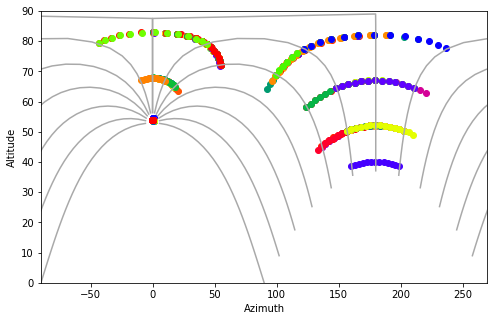

In [251]:
plt.figure(figsize=[8,5])

# Plot lines of constant +/-6 hours in HA.
obj=np.zeros(len(dec))
obj_alt1=np.zeros(len(dec))
obj_az1=np.zeros(len(dec))
for h in ha_intervals:
    for d in range(len(dec)):
        obj1 = SkyCoord(lst_dummy+h*u.hourangle,dec[d],unit=(u.hourangle, u.deg))
        obj_az1[d] = ((obj1.transform_to(AltAz(obstime=t,location=westerbork))).az*u.deg).value
        obj_alt1[d] = ((obj1.transform_to(AltAz(obstime=t,location=westerbork))).alt*u.deg).value
    plt.plot(obj_az1[0:-1],obj_alt1[0:-1],color='darkgray',linestyle='-')
    plt.plot(-1*obj_az1[0:-1],obj_alt1[0:-1],color='darkgray',linestyle='-')

# Plot tracks of RFI scans:
for i in range(len(rfi_scans)):
    for j in range(len(obj_altazs[0])):
        if obj_altazs[i,j] != 0:
            plt.scatter((obj_altazs[i,j].az*u.deg).value,(obj_altazs[i,j].alt*u.deg).value,color=cmap(norm(i)))
            if (obj_altazs[i,j].az*u.deg).value > 270.:
                plt.scatter((obj_altazs[i,j].az*u.deg).value-360,(obj_altazs[i,j].alt*u.deg).value,color=cmap(norm(i)))
            
#plt.plot([180,180],[0,90],c='darkgray')  #South
#plt.plot([0,0],[0,90],c='darkgray')      #North

plt.xlabel("Azimuth")
plt.xlim(-90,270)
plt.ylabel("Altitude")
plt.ylim(0,90)
plt.title("Alt-Az Distribution of RFI Scans")

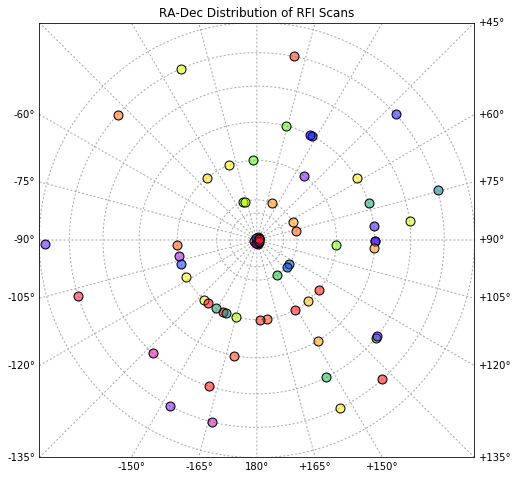

In [261]:
# Now let's plot as a function of RA and Dec (this is way easier).

# Set up the map projection
plt.figure(figsize=[8,8])
m = Basemap(projection='nplaea',boundinglat=0.1,lon_0=180,resolution='l',celestial=True)
m.drawparallels(np.arange(0,100,15),labels=[False,False,False,False],color='darkgray')
m.drawmeridians(np.arange(0,360,15),labels=[True,True,False,True],color='darkgray',latmax=90)

# Plot the locations of the RFI scans
for i in range(len(rfi_scans)):
    obj = SkyCoord(rfi_scans['col7'][i],rfi_scans['col8'][i],unit=(u.hourangle, u.deg))
    xpt,ypt=m((obj.ra*u.deg).value,(obj.dec*u.deg).value)
    m.plot(xpt,ypt,'o',markersize=8,label='',color=cmap(norm(i)),alpha=0.5)
    m.plot(xpt,ypt,'o',markersize=9,label='',mfc='none',color='black')

plt.title("RA-Dec Distribution of RFI Scans")
